<a href="https://colab.research.google.com/github/laura-turnbull-lloyd/STDH_teaching/blob/main/Lecture_4_analysing_spatial_patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Today we're going to be focussing on analysing the spatial distribution of hazards and looking at event effectiveness.

You'll be working with a spatial dataset consisting of polygons representing landslides that occurred during the 2008 Mw 7.9 Wenchuan earthquake in China. The data represent an area of 20 x 20 km.


## Packages we'll be working with

GeoPandas -- which offers a pandas-like interface to working with geodata. Think of this as your tool for basic data manipulation and transformation, much like pandas. To ensure that geopandas (and its dependencies) are correctly installed, make sure you run the package install script as detailed below (there are a few issues with installing geopandas correcty on google colab!).

The other packages listed are those that you've worked with before, or packages that geopandas depends on.

In [2]:
!pip install pandas fiona shapely pyproj rtree

import pandas as pd
# to make sure that pandas outputs values in an easy to read format, we can customise the output format:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import numpy as np
import matplotlib.pyplot as plt
!pip install geopandas
import geopandas as gpd
import shapely
import pyproj
import rtree
import requests
import zipfile
import io
import seaborn

#Reading in landslide data
The data have been provided for you in a shapefile format, in a zipped up file for you on GitHub. In the script below, you will automatically extract the data from GitHub (so no need to download it).

In case you also wish to explore the data in a more traditional Geogrpahical Infromation System (e.g. ArcPro or QGIS), I have also provided the data for you on Learn Ultra on this weeks page.


To read in the data from GitHub and view the data:

In [4]:
# read in data that's provided for you on Github
url = "https://github.com/laura-turnbull-lloyd/STDH_teaching/raw/main/landslides_clip.zip"

# Download the zip file into memory
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

In [9]:
# read in the shapefile

z.extractall("landslides_clip")
LS = gpd.read_file("landslides_clip") # this reads in the landslide data

# Let's view the header info of the landslide data we've just read in
LS.head()


,ID,area_rob,data,geometry
0,37469,500.00000,rnp,"POLYGON ((376386.922 3469995, 376366.922 34699..."
1,37470,1600.00000,rnp,"POLYGON ((383916.922 3469995, 383896.922 34699..."
2,37471,3100.00000,rnp,"POLYGON ((384546.922 3469995, 384536.922 34699..."
3,37475,3800.00000,rnp,"POLYGON ((377946.922 3469995, 377946.922 34699..."
4,37476,2500.00000,rnp,"POLYGON ((388336.922 3469985, 388316.922 34699..."


Alternatively we can print out the whole dataset which will show us the first and last few lines in the dataset:

In [8]:
#Printing out the whole dataset
LS

,ID,area_rob,data,geometry
0,37469,500.00000,rnp,"POLYGON ((376386.922 3469995, 376366.922 34699..."
1,37470,1600.00000,rnp,"POLYGON ((383916.922 3469995, 383896.922 34699..."
2,37471,3100.00000,rnp,"POLYGON ((384546.922 3469995, 384536.922 34699..."
3,37475,3800.00000,rnp,"POLYGON ((377946.922 3469995, 377946.922 34699..."
4,37476,2500.00000,rnp,"POLYGON ((388336.922 3469985, 388316.922 34699..."
...,...,...,...,...
6599,54720,2200.00000,rnp,"POLYGON ((373546.922 3450015, 373546.922 34500..."
6600,54731,4100.00000,rnp,"POLYGON ((377756.922 3450000, 377716.922 34500..."
6601,54756,12500.00000,rnp,"MULTIPOLYGON (((375156.922 3450000, 375106.922..."
6602,54882,14500.00000,rnp,"POLYGON ((373366.922 3450025, 373366.922 34500..."


You can see that there are 6604 rows in the data, which means there are 6604 individual landslide polygons.

Note that python is a bit wierd in that it starts its index numbering from zero.

Each row in the landslide dataset contains a unique identifier (in column ID), the area of the polygon in m2 (area_rob), the initials of the person who mapped it (data), and the geometry of the data (geometry). These attributes are linked to each individual landslide polygon.

Using the `gpd.read_file`command, you read the data into a a 'geodataframe', which is very similar to a traditional, non-spatial pandas DataFrame, but with an additional column called geometry.

#Determining the coordinate system of the data
It's important to be aware of the coordinate system if the data you're working with. You can find it out using the ```crs``` command. It's easy to make mistakes in spatial data analysis when you aren't aware of the coordinate system of your data. This becomes even more important when you are working with more than one dataset.



In [10]:
LS.crs

<Projected CRS: EPSG:32648>
Name: WGS 84 / UTM zone 48N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 102°E and 108°E, northern hemisphere between equator and 84°N, onshore and offshore. Cambodia. China. Indonesia. Laos. Malaysia - West Malaysia. Mongolia. Russian Federation. Singapore. Thailand. Vietnam.
- bounds: (102.0, 0.0, 108.0, 84.0)
Coordinate Operation:
- name: UTM zone 48N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Plotting spatial data
We can plot the raw spatial data using the code below. In this code, we undertake the following steps:
1. Create a figure named f with one axis named ax by using the command plt.subplots (part of the library matplotlib, which we have imported at the top of the notebook).
Note how the method is returning two elements and we can assign each of them to objects with different name (f and ax) by simply listing them at the front of the line, separated by commas.
2. We plot the geographies and tell the function that we want it to draw the polygons on the axis we are passing, ax. This method returns the axis with the geographies in them, so we make sure to store it on an object with the same name, ax.
3. We draw the entire plot by calling plt.show().

For more information on matplotlib plotting conventions, see [here](https://matplotlib.org/stable/tutorials/introductory/).

You can also save figures outside of this notebook, using the ```plt.savefig``` command -- see below for an example. Any figures you save will be saved in the current working directory and therefore will need to be moved if you want to access them after the session has ended.



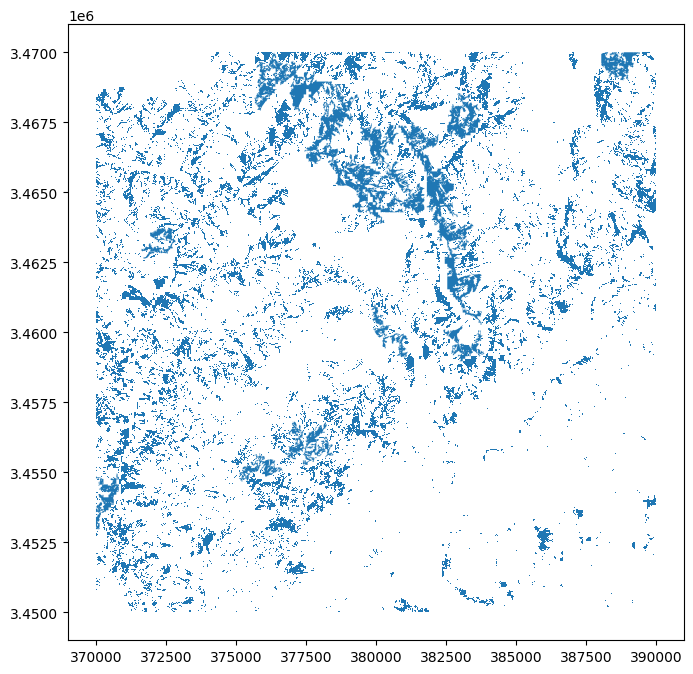

<Figure size 640x480 with 0 Axes>

In [11]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(16, 8))
# Plot layer of polygons on the axis
LS.plot(ax=ax)
# Remove axis frames
#ax.set_axis_off()
# Display
plt.show()

# Save figure to a PNG file
plt.savefig('Wenchuan_landslides.png')

plt.tight_layout()

# For a very high resolution image we can add the dpi in the command, e.g.
#plt.savefig('Wenchuan_landslides.png', dpi = 1080) # I've left this line commented, as you don't need to run it for now.


As we've established over the previous weeks, it's always useful to undertake exploratory data analysis to establish key characteristics about the data (hazard) that we're working with.

We can use the pandas summary statistics (describe) function to be able to explore the data.

The describe funciton gives the:
> count

> mean

> standard deviation

> minimum

> 25 percentile

> 50 percentile

> 75 percentiles

> max

of all numeric columns in the dataset


In [12]:
LS.describe()

,ID,area_rob
count,6604.00000,6604.00000
mean,45827.33677,9574.74258
std,4891.00143,81665.57068
min,37469.00000,400.00000
25%,41495.75000,600.00000
50%,45753.50000,1100.00000
75%,49935.25000,3000.00000
max,54883.00000,3197700.00000


**What's the maximum landslide size (including correct units)?**



For other summary infromation that is not given by the describe funciton, we can calculate this manually. For instance, we might be interested in the total area of landslides in the study area. We can calculate this using the pandas 'series sum' function.

In [13]:
total_area = pd.Series(LS['area_rob'].sum(), index=['area_rob'])
print(total_area)

area_rob   63231600.00000
dtype: float64


**What's the total area affected by landslides in the study area?**

**What percentage of the entire study area is affected by landslides?**
To answer this question you will have to undertake a further calculation which you can enter below:




In [17]:
#Add your calculations here in order to answer the above question:
study_area = 20000*20000
percent_LS = total_area/study_area*100
percent_LS

,0
area_rob,15.80790


#Exercise 1: Point pattern analysis
Let's explore patterns in the landslide data. First, we'll explore landslide patterns by prepresenting them as points. To do this we extract a point (the centroid) from the landslide polygons that we've just been exploring.

In [ ]:
#extracting points from the landslide polygons
points = LS.copy()
# change geometry
points['geometry'] = points['geometry'].centroid
points

As we've already established, the first step to get a sense of what the spatial dimension of this dataset looks like is to plot it.

In [ ]:
f, ax = plt.subplots(1, figsize=(12, 8))
points.plot(ax=ax) # this is the landslide data represented as points
plt.autoscale(True)
plt.tight_layout()

You can see that this plot is very cluttered. To deal with this, we can view it as a spatial or 2-D histogram. Here, we generate a regular grid (either squared or hexagonal), count how many dots fall within each grid cell. This is attractive because it is simple and intuitive.

First, let's create the regular grid.

In [ ]:
from shapely.geometry import Polygon

# total area for the grid
xmin, ymin, xmax, ymax= LS.total_bounds # this function extracts the bounding coordinates of the landslide data
width = 500
height = 500
# projection of the grid - this sets the crs to be the same as the data we area already working with
crs = LS.crs
rows = int(np.ceil((ymax-ymin) /  height))
cols = int(np.ceil((xmax-xmin) / width))
XleftOrigin = xmin
XrightOrigin = xmin + width
YtopOrigin = ymax
YbottomOrigin = ymax- height
polygons = []
for i in range(cols):
   Ytop = YtopOrigin
   Ybottom =YbottomOrigin
   for j in range(rows):
       polygons.append(Polygon([(XleftOrigin, Ytop), (XrightOrigin, Ytop), (XrightOrigin, Ybottom), (XleftOrigin, Ybottom)]))
       Ytop = Ytop - height
       Ybottom = Ybottom - height
   XleftOrigin = XleftOrigin + width
   XrightOrigin = XrightOrigin + width

grid = gpd.GeoDataFrame({'geometry':polygons}, crs=crs)
grid

Next, we'll create a new object called `landslide_count` and store the result of a spatial join between landslide points and the grid.

In [ ]:
landslide_count = gpd.sjoin(grid, points, how='left', predicate ='contains')
landslide_count

Each landslide carries the ID of its corresponding grid cell (on the far left of the above table). Let's explicitly add this grid cell ID to the geodataframe:

In [ ]:
landslide_count['grid_index'] = landslide_count.index
landslide_count

Now we want to count the number of landslides in each grid cell. We can do this using the dissolve tool (which simplifies data), counting the number of landslides within each grid cell.

In [ ]:
landslide_count_dissolve = landslide_count.dissolve(by='grid_index', aggfunc='count')
landslide_count_dissolve

In the table above, you can see that for the attributes that were associated with the landslide point data, you now have the 'count' of how many landslides there were in each grid cell.

So, for example, for grid cell with an index of 3, there were 7 landslide points within that cell. Whilst for grid cell with an index of 0, there were 0 landslides.

We can now plot out the resulting landslide point density map.

In [ ]:
f, ax = plt.subplots(1, figsize=(12, 8))
landslide_count_dissolve.plot(ax=ax, column='index_right', cmap='jet', legend = True) # here, cmap = 'jet' specifies the colour ramp I've chosen to use.
plt.autoscale(True)
grid.plot(ax=ax, facecolor="none", edgecolor='grey') # this is where you overlay the grid

## Summarising spatial patterns using a kernel density estimate

We can also summarise the spatial distribution of points using a kernel density function. This is simple to achieve using the seaborn package.

A kernel density function replaces plotting every single point by estimating the continuous observed probability distribution. It's not too dissimilar to the point densiyt counts that you've just carried out, but it differs in that it abstracts a surface that models the probability of point density over space. The idea behind kernel density estimates is to count the number of points in a continious way. Instead of using discrete counting, where you include a point in the count if it is inside a certain boundary and ignore it otherwise, KDEs use functions (kernels) that include points but give different weights to each one depending of how far of the location where we are counting the point is.

To use the functions contained within the seaborn package, we need x and y coordinates of the points.

In [ ]:
points["x"] = points.geometry.x
points["y"] = points.geometry.y

Once you have these x and y coordinates, creating a kernel density estimate is very straightfoward in Python. In its simplest form, we can run the following single line of code:

In [ ]:
seaborn.kdeplot(data = points, x = "x", y = "y", shade=True, cmap='viridis', cbar = True)

Much like with the bin size in the histogram, the ability of the kernel density estimate to accurately represent the data depends on the choice of smoothing bandwidth. An over-smoothed estimate might erase meaningful patterns, but an under-smoothed estimate can obscure the true patterns within random noise. The easiest way to check the robustness of the estimate is to adjust the default bandwidth (which is a backend calculation in seaborn using scipy, and is based on the distribution of the data).

**Add a bw_adjust function (e.g. ```bw_adjust = 0.5```) to the code below, and have a play around to see how different values of bw_adjust alter the resulting kernel density estimation.**

In [ ]:
seaborn.kdeplot(data = points, x = "x", y = "y", shade=True, cmap='viridis', cbar = True)

You can read more about the different parameter options for kernel density estimates using the seaborn package [here](https://seaborn.pydata.org/generated/seaborn.kdeplot.html).

#Exercise 2: Landslide area density
To undertake density calculations, we need to divide the study area up into regions within which we are going to undertake density calculations.

We can do this using the geopandas package.




Plotting the grid over the data shows how the landslides are generally clustered into a few regions and we’ll end up with many “empty” grid cells:

In [ ]:
f, ax = plt.subplots(1, figsize=(12, 8))
LS.plot(ax=ax) # this is the landslide data
plt.autoscale(True)
grid.plot(ax=ax, facecolor="none", edgecolor='grey') # this is where you overlay the grid!
plt.tight_layout()

We’re going to determine the area of landslides in each square polygon. This takes a couple of steps in GeoPandas.

First, we use the intersect tool to divide up the landslide polygons based on the grid cells. Then we calculate the area of each fragmented landslide polygon, and add the landslide index to the dataframe (just to make sure it gets carried over into the subsequent analysis).

In [ ]:
#LS_intersection = LS.overlay(cell, keep_geom_type = False)
LS_intersect = LS.overlay(grid, how='intersection', keep_geom_type=False)
LS_intersect['LS_area'] =LS_intersect.apply(lambda row: row.geometry.area,axis=1) # calculate the area of each landslide segment
LS_intersect['LS_index'] = LS_intersect.index
print(LS_intersect)


We can plot out the data to check it looks sensible...

In [ ]:
f, ax = plt.subplots(1, figsize=(25, 15))
LS_intersect.plot(ax=ax, facecolor = "none", edgecolor = 'red')
plt.autoscale(True)
#cell.plot(ax=ax, facecolor="none")#, edgecolor='grey') # this is where you overlay the grid

This looks good. You can clearly see where landslide polygons have been divided up where they cross grid cells.

The next task is to undertake a spatial join, to join the landslide data to the grid.We do this using the geopandas spatial join, ```sjoin``` tool.



In [ ]:
merged = gpd.sjoin(grid, LS_intersect, predicate = 'contains', how='left')
merged

**Why do you think that some rows in the dataframe have NaN values?**

As we did before, we'll add the grid index to the dataframe:

In [ ]:
merged['grid_index'] = merged.index # here, we add the index of the cells covering the study area into the dataframe so that we can use this in our analysis

In [ ]:
merged

Now we want to sum up the area of landslides in each grid cell. In case there are more than one landslide per grid cell, we can dissolve the data, i.e. making the data more sparse, or in otherwords combine information (landslide area) from individual landslide polygons, to a total landslide area per grid cell.

In [ ]:
# Compute stats per grid cell -- aggregate landslides to grid cells with dissolve
dissolve_merged = merged.dissolve(by='grid_index', aggfunc='sum') # sums up all the values in the area column
dissolve_merged

Next, to help with landslide area density calculations, we need to total area of each grid cell. There are multiple ways we can calculate this (we specified the dimensions of each grid cell earlier). I always like to calculate dimensions based on the actual data, as there's less room for error.

In [ ]:
dissolve_merged['cellarea'] =dissolve_merged.apply(lambda row: row.geometry.area,axis=1)
dissolve_merged

# Note that when you write out the dataframe, there's a little blue pen, which you can click to work interactivley with the dataframe, for instance if you want to interrogate the data manually.

Now you've got the area of landsides in each grid cell you can finally calculate the landslide area density, which is simply the area of landslides in each cell, divided by the area of that cell, multiplied by 100, to give landslide area as a %.


In [ ]:
dissolve_merged['area_density'] = (dissolve_merged['LS_area']/dissolve_merged['cellarea'])*100
dissolve_merged

Finally, to plot the end product of this analysis:

In [ ]:
f, ax = plt.subplots(1, figsize=(12, 8))
dissolve_merged.plot(ax=ax, column='area_density', cmap='jet', legend = True) # here, cmap = 'jet' specifies the colour ramp I've chosen to use.
plt.autoscale(True)
grid.plot(ax=ax, facecolor="none", edgecolor='grey') # this is where you overlay the grid


In Exercise 1 you calculated the point density of landslides and explored kernel density estimates. In Exercise 2 you calculated the area density of landslides.

**Compare and contrast the resulting patterns of landslides from these different types of analyses. Have a think about which approach is most useful and why, given different hazards we're interested in, and the different data formats available to us (e.g. point/polygon/line) representations of hazards**



##Extra task
Have a play around with the grid size and evaluate effects of changing cell size on the resulting patterns of landslide area density.

# Exercise 3: Event effectiveness

Linking back to the first part of the lecture on event effectiveness, to be able to determine effectiveness, we must be able to
  1.	convert landslide area to some measure of effect, and
  2.	calculate the effect of landslides in each size bin

A reasonable measure of landslide ‘effect’ is the landslide volume – this indicates the amount of erodible sediment that was created by the landslide, and which may have hazardous impacts as it is mobilized and moved downstream. To determine this, we need to use an empirical scaling relationship to convert area to volume. For a sample of landslides that occurred following the Wenchuan earthquake, Parker et al (2011) found the relationship to be:
\begin{equation}
    \ V = 0.106 A^{1.388}
\end{equation}
where *A* is area in m<sup>2</sup> and *V* is volume in m<sup>3</sup>.


In a later study, [Xu et al (2016)](https://www.nature.com/articles/srep29797) found that:
\begin{equation}
    \ V = 0.135 A^{1.208}
\end{equation}


We can then apply this area-volume scaling relationship to each individual landslide, and then sum up the individual volumes.





In [ ]:
LS["volume"] = 0.106*LS.area_rob**1.388


To divide the data into bins, you can use the following code to cut the data into bins, and then group the data into these different bins.

In [ ]:
g = pd.cut(LS['area_rob'], bins=np.logspace(np.log10(min(LS.area_rob)),np.log10(max(LS.area_rob)), 30)) # The cut function converts continuous data into discrete bins.
summaryLS = LS.groupby(g, observed=True).agg(area_count=('area_rob','count'), volume_sum=('volume','sum')).astype(float)
summaryLS['index1'] = summaryLS.index



In [ ]:
summaryLS

In [ ]:
values = np.logspace(np.log10(min(LS.area_rob)),np.log10(max(LS.area_rob)), 30)
values = values[1:] # this line of code removes the first value form the array because for the sake of plotting the data, we'll take the upper limit of each bin interval
print(values)

In [ ]:
volume_sum = np.array(summaryLS.volume_sum)
#print(volume_sum)

The 'volume_sum' is the effectiveness; i.e. the sum of individual landslide volumes in each bin.

We can also plot out how landslide volume changes according to the equation above:


In [ ]:
Volume = 0.106*values**1.388
#print(Volume)

In [ ]:
fig, ax = plt.subplots()
ax.plot(values, summaryLS.area_count, color = 'red', label = 'frequency')
ax.plot(values, Volume, color = 'green', label = 'volume')
ax.plot(values, summaryLS.volume_sum, color = 'blue', label = 'effectiveness')
ax.set_xlabel("Area m^2")
ax.set_ylabel("Frequency/Volume m^3/Effectiveness m^3")
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
plt.show()



**What do you observe about changes landslide effectiveness with an increase in landslide area?**
**What are some limitations/uncertainties of this analysis?**

## Extra task
In the above task, we calculated landslide effectiveness using the Parker et al (2011) equation. How different is landslide effectiveness when calculated using the Xu et al (2016) area to volume relation? Differences in the results indicante a source of uncertainty in our estimatation of landslide effectiveness.
What might other sources of uncertainty be?

Linking back to the work you've undertaken during the previous few weeks, you could explore the frequency magnitude distribution of the landslides. Do they fit a powerlaw distribution in the same way that the earthquakes we've explored in the previous few weeks do?